# Tarea Semanal 5: Simulación de un ADC (cuantización, muestreo y alias)
## Magdalena Noé
Se simulará un ADC incluyendo capacidad de muestrear a $f_s$ [Hz], con una señal analogica muestreada a $f′_S=k_O.f_S$, siendo $k_O$ el factor de sobremuestreo. Se adoptará una potencia de ruido analógico igual al ruido de cuantización.

Primero se generarán dichas señales, con y sin oversampling, analizando sus diferencias.

Luego se aplicará un filtro pasabajos a la señal con oversampling, eliminando el alias, para apreciar la ventaja en definición que trae esta práctica. Por otro lado se generarán 4 casos en donde no se usa el filtro pasabajos de forma correcta, demostrando el efecto alias y las consecuencias que tiene en la señal.

- $f_c > 1/k_o$:     Parte de los valores superan el ancho de banda original, superponiendose entre sí (efecto alias)
- $f_c << 1/k_o$:    Se filtra por debajo del ancho de banda original, perdiendo informacion de la señal innecesariamente
- $f_c < 1/k_o$ pero N=1:    Se respeta el límite de de Nyquist pero el filtro es de orden bajo (ligero efecto alias)
- $∄$:      La señal no se filtra (máximo efecto alias)

### Librerías

In [229]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import butter, lfilter
import scipy.signal as sig
from numpy.fft import fft #Para poder escribir fft() en vez de numpy.fft.fft()

#### Parámetros generales

In [230]:
fs = 1000       # Frecuencia de muestreo [Hz]
ko = 10          # Factor de sobremuestreo
fs_os = fs * ko # Frec de muestreo con oversamp
ts_os = 1/fs_os
N = fs          # cantidad de muestras
N_os = N * ko   # cantidad de muestras con oversamp
fo = fs/N # [Hz]

Vmax = np.sqrt(2) #[Volts]
df = fs/N # resolución espectral

# RUIDO #
Vf = 2 #[Volts] 
B = 4 # Bits
q = Vf/2**(B)

kn = 1
Pq = q**2/12
Pn = kn * Pq # Pot ruido [Watts]

#### Generación, contaminación y cuantificación de la señal

In [231]:
tt = np.arange(N) / fs
s = Vmax * np.sin(tt*2*np.pi*fo)

tt_os = np.arange(N_os) / fs_os
s_os = Vmax * np.sin(tt_os*2*np.pi*fo)

n = np.random.normal(loc=0, scale=np.sqrt(Pn), size=N) # Ruido
sr = s + n
srq = np.round(sr / q) * q # Cuantizacion
nq = srq - sr

n_os = np.random.normal(loc=0, scale=np.sqrt(Pn), size=N_os) # Ruido
sr_os = s_os + n_os
srq_os = np.round(sr_os / q) * q # Cuantizacion
nq_os = srq_os - sr_os # Error de cuantizacion


Graficamos las señales para apreciar sus diferencias

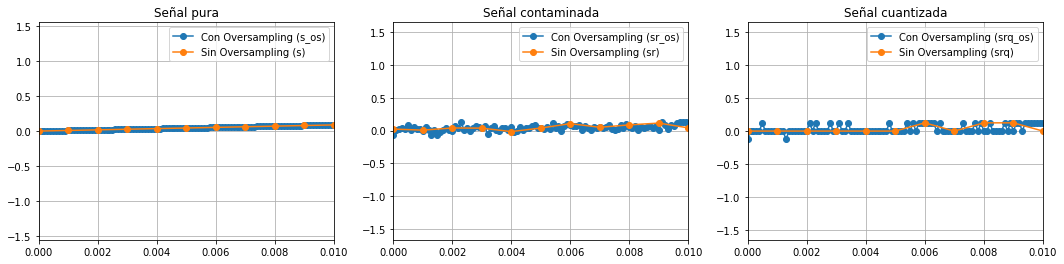

In [232]:
plt.figure(figsize=(18, 4))

plt.subplot(1,3,1)
plt.plot(tt_os, s_os, 'o-', label='Con Oversampling (s_os)')
plt.plot(tt, s, 'o-', label='Sin Oversampling (s)')
plt.legend(); plt.grid();  plt.xlim(0, 0.01);plt.title("Señal pura")

plt.subplot(1,3,2)
plt.plot(tt_os, sr_os, 'o-', label='Con Oversampling (sr_os)')
plt.plot(tt, sr, 'o-', label='Sin Oversampling (sr)')
plt.legend(); plt.grid();  plt.xlim(0, 0.01);plt.title("Señal contaminada")

plt.subplot(1,3,3)
plt.plot(tt_os, srq_os, 'o-', label='Con Oversampling (srq_os)')
plt.plot(tt, srq, 'o-', label='Sin Oversampling (srq)')
plt.legend(); plt.grid();  plt.xlim(0, 0.01);plt.title("Señal cuantizada")
plt.show()

## Filtrado del alias apropiado
A continuación se filtra la señal con oversampling cuantificada con un filtro butter de sexto grado y una frecuencia de corte igual a la inversa del factor de sobremuestreo. Luego se diezmara la misma para "eliminar" el efecto oversampling, tomando un valor de cada $k_o$ valores

In [299]:
orden_filtro = 6
atenuacion_rechazo_db = -20 # Atenuacion minima a partir de f_objetivo
f_objetivo = (fs/2) # Frecuencia de corte deseada (Limite de Nyquist)
fc = f_objetivo*0.5         # Frecuencia a la que se empieza a atenuar
fc_norm = fc / (fs / 2) # Frecuencia de corte normalizada

coef_num, coef_den = sig.butter(orden_filtro, fc_norm, btype='low', analog=False)

arr_fobjetivo = []; arr_fobjetivo.append(f_objetivo) # Añado valor al array
arr_ord = []; arr_ord.append(orden_filtro)
arr_coef_num = []; arr_coef_num.append(coef_num)
arr_coef_den = []; arr_coef_den.append(coef_den)
arr_fc = []; arr_fc.append(fc)

#coef_num, coef_den = butter(orden_filtro, Wn)
s_filtrada = lfilter(coef_num, coef_den, srq_os)

# Diezmamos
s_diezmada = s_filtrada[::ko]
tt_diezmada = tt_os[::ko]

n_diez = s_diezmada - s # Error con señal analogica
n_r = sr - s # Error con señal analogica

Graficamos la señal filtrada y diezmada en tiempo, y la densidad espectral de potencia del ruido.

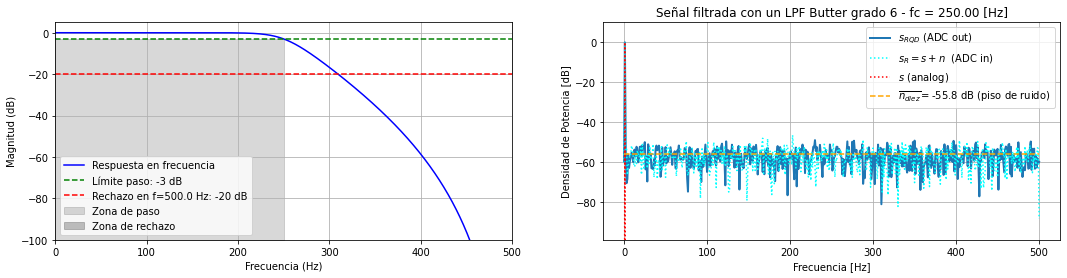

In [300]:
plt.figure(4, figsize=(18, 4))
plt.subplot(1,2,1)

'''GRAFICO RESPUESTA EN FRECUENCIA'''
def graficar_plantilla_filtro_iir(b, a, fc, f_objetivo, atenuacion_rechazo_db, atenuacion_paso_db=-3, fs=1.0, color='blue'):
    """
    Parámetros:
    - b, a: coeficientes del filtro IIR
    - fc: frecuencia de corte en Hz (usada solo para graficar la banda de paso)
    - f_objetivo: frecuencia objetivo donde se espera la atenuación de rechazo (Hz)
    - atenuacion_rechazo_db: dB deseados de rechazo a partir de f_objetivo
    - atenuacion_paso_db: dB máximos permitidos en la banda de paso
    - fs: frecuencia de muestreo en Hz
    """
    # Respuesta en frecuencia
    worN = 1024
    w, h = sig.freqz(b, a, worN=worN, fs=fs)
    
    # Frecuencia normalizada para graficar (de 0 a 1)
    f = w / np.pi
    h_db = 20 * np.log10(np.abs(h) + 1e-12)  # evitar log(0)

    # Rango de dB para la gráfica
    y_min, y_max = -100, 5

    # Graficar respuesta y plantilla
    plt.plot(w, h_db, label='Respuesta en frecuencia', color=color)

    # Banda de paso
    plt.fill_betweenx([y_min, atenuacion_paso_db], 0, fc, color='gray', alpha=0.3, label='Zona de paso')

    # Banda de rechazo
    plt.fill_betweenx([atenuacion_rechazo_db, y_max], f_objetivo, fs/2, color='gray', alpha=0.5, label='Zona de rechazo')

    # Líneas guía
    plt.axhline(y=atenuacion_paso_db, color='green', linestyle='--', label=f'Límite paso: {atenuacion_paso_db} dB')
    plt.axhline(y=atenuacion_rechazo_db, color='red', linestyle='--', label=f'Rechazo en f={f_objetivo} Hz: {atenuacion_rechazo_db} dB')

    # Estética
    plt.xlabel('Frecuencia (Hz)')
    plt.ylabel('Magnitud (dB)')
    plt.grid(True)
    plt.ylim([y_min, y_max])
    plt.xlim([0, fs / 2])
    plt.legend()

graficar_plantilla_filtro_iir(coef_num, coef_den, fc, f_objetivo, atenuacion_rechazo_db, atenuacion_paso_db=-3, fs=fs)

'''GRAFICO PSD'''
plt.subplot(1,2,2)
# ffts constantes para todo filtrado, arbitrarias a recalcular cada vez que se llama a la funcion
nNn = np.random.normal(0, np.sqrt(Pn), size=N_os) # Ruido oversampling
ft_Nn = fft(nNn) / N_os
nNn_mean = np.mean(np.abs(ft_Nn)**2)
ft_SR = fft(sr) / N             # Seno con ruido
ft_As = fft(s_os) / N_os        # Seno puro

# Calculamos PSD
def grafico_PSD(error, fcorte, orden_filtro, s_diezmada):
    
    ff = np.arange(0,fs,df) #ff = np.fft.fftfreq(N, d=1/fs)
    ff_os = np.arange(0,fs_os,df)  #ff_os = np.fft.fftfreq(N_os, d=df) # Reemplazar ffreq

    fft_n = fft(error) / N
    Nnq_mean = np.mean(np.abs(fft_n)**2)

    ft_Srqd = fft(s_diezmada) / N           # Seno con ruido cuantizada, filtrada y diezmada

    bfrec = ff <= fs/2
    # Señal de salida (cuantificada y diezmada) densidad de potencia
    plt.plot( ff[bfrec], 10* np.log10(2*np.abs(ft_Srqd[bfrec])**2), lw=2, label='$ s_{RQD} $ (ADC out)' )
    # Señal analogica de entrada (con ruido) densidad de potencia
    plt.plot( ff[bfrec], 10* np.log10(2*np.abs(ft_SR[bfrec])**2), color='cyan', ls='dotted', label='$ s_R = s + n $  (ADC in)' )
    # Señal analogica pura densidad de potencia
    plt.plot( ff_os[ff_os <= fs/2], 10* np.log10(2*np.abs(ft_As[ff_os <= fs/2])**2), color='red', ls='dotted', label='$ s $ (analog)' )
    # Piso ruido cte
    plt.plot( np.array([ ff[bfrec][0], ff[bfrec][-1] ]), 10* np.log10(2* np.array([Nnq_mean, Nnq_mean]) ), '--c', color='orange', label='$ \overline{n_{diez}} = $' + '{:3.1f} dB (piso de ruido)'.format(10* np.log10(2* Nnq_mean)) )
    plt.title('Señal filtrada con un LPF Butter grado {:d} - fc = {:3.2f} [Hz]'.format(orden_filtro, fcorte) )
    plt.ylabel('Densidad de Potencia [dB]'); plt.xlabel('Frecuencia [Hz]')
    axes_hdl = plt.gca(); axes_hdl.legend()
    plt.ylim((1.5*np.min(10* np.log10(2* np.array([Nnq_mean, nNn_mean]))),10)); plt.grid()

grafico_PSD(error = n_diez, fcorte = fc, orden_filtro = orden_filtro, s_diezmada = s_diezmada)
plt.show()

## Experimentación de los filtros
En el caso anterior se respetaba el límite de Nyquist para crear el filtro ideal, donde se evita el efecto aliasing pero se pierde la menor cantidad de la señal posible.
Ahora experimentamos con los 4 casos definidos al inicio.

##### Caso 1: $f_c > fs/2$

In [301]:
orden_filtro = 6
atenuacion_rechazo_db = -20 # Atenuacion minima a partir de f_objetivo
f_objetivo = 1.5*(fs/2) # Frecuencia de corte deseada
fc = f_objetivo*0.5         # Frecuencia a la que se empieza a atenuar
fc_norm = fc / (fs / 2) # Frecuencia de corte normalizada

coef_num, coef_den = sig.butter(orden_filtro, fc_norm, btype='low', analog=False)

arr_fc.append(fc); arr_fobjetivo.append(f_objetivo); arr_ord.append(orden_filtro)
arr_coef_num.append(coef_num); arr_coef_den.append(coef_den)

s_filtrada = lfilter(coef_num, coef_den, srq_os)

# Diezmamos
s_1 = s_filtrada[::ko]
tt_1 = tt_os[::ko]
n_1 = s_1 - s # Error con señal analogica


##### Caso 2: $f_c << fs/2$

In [302]:
orden_filtro = 6
atenuacion_rechazo_db = -20 # Atenuacion minima a partir de f_objetivo
f_objetivo = 0.2*(fs/2) # Frecuencia de corte deseada
fc = f_objetivo*0.5         # Frecuencia a la que se empieza a atenuar
fc_norm = fc / (fs / 2) # Frecuencia de corte normalizada

coef_num, coef_den = sig.butter(orden_filtro, fc_norm, btype='low', analog=False)

arr_fc.append(fc); arr_fobjetivo.append(f_objetivo); arr_ord.append(orden_filtro)
arr_coef_num.append(coef_num); arr_coef_den.append(coef_den)

s_filtrada = lfilter(coef_num, coef_den, srq_os)

# Diezmamos
s_2 = s_filtrada[::ko]
tt_2 = tt_os[::ko]
n_2 = s_2 - s # Error con señal analogica

##### Caso 3: Orden de filtro bajo

In [303]:
orden_filtro = 1
atenuacion_rechazo_db = -20 # Atenuacion minima a partir de f_objetivo
f_objetivo = (fs/2) # Frecuencia de corte deseada
fc = f_objetivo*0.5         # Frecuencia a la que se empieza a atenuar
fc_norm = fc / (fs / 2) # Frecuencia de corte normalizada

coef_num, coef_den = sig.butter(orden_filtro, fc_norm, btype='low', analog=False)

arr_fc.append(fc); arr_fobjetivo.append(f_objetivo); arr_ord.append(orden_filtro)
arr_coef_num.append(coef_num); arr_coef_den.append(coef_den)

s_filtrada = lfilter(coef_num, coef_den, srq_os)

# Diezmamos
s_3 = s_filtrada[::ko]
tt_3 = tt_os[::ko]
n_3 = s_2 - s # Error con señal analogica

##### Caso 4: Sin filtro

In [304]:
arr_fc.append(0); arr_fobjetivo.append(0); arr_ord.append(0)
arr_coef_num.append(0); arr_coef_den.append(0)

# Diezmamos
s_4 = srq_os[::ko]
tt_4 = tt_os[::ko]
n_4 = s_4 - s # Error con señal analogica

## Comparación gráfica

c:\Users\Magdalena\AppData\Local\Programs\Python\Python36\lib\site-packages\scipy\signal\filter_design.py:456: RuntimeWarning: invalid value encountered in true_divide
  h /= a


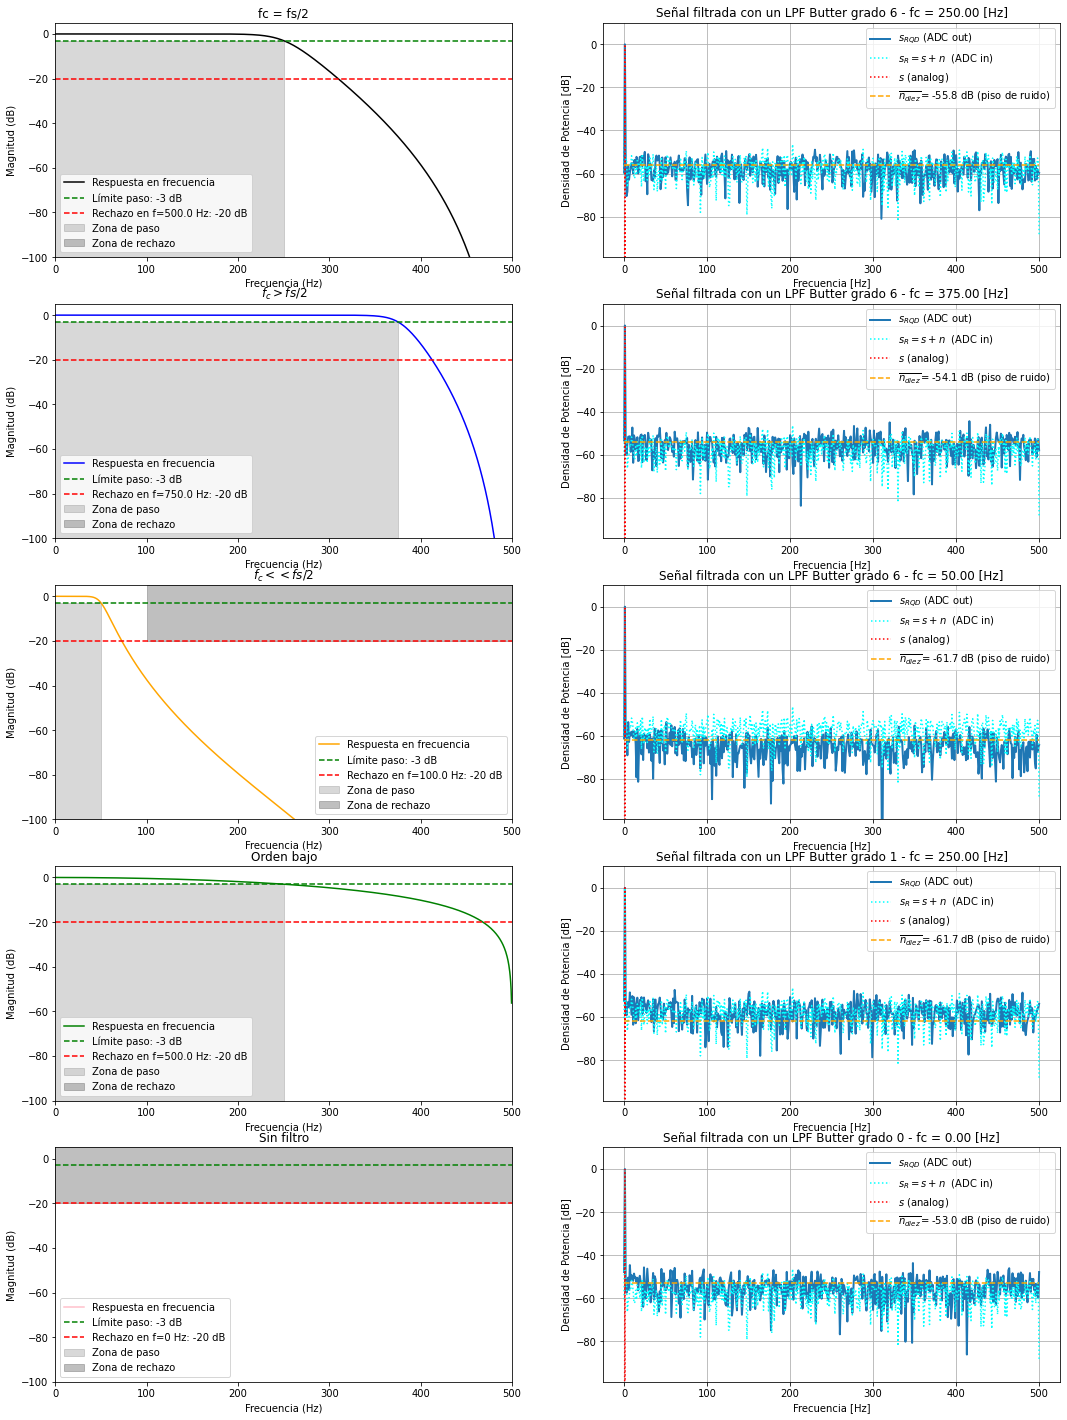

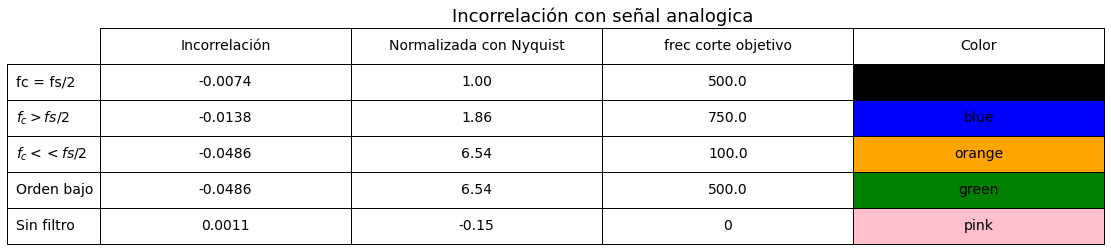

In [305]:
arr_s = [s_diezmada, s_1, s_2, s_3, s_4]
arr_tt = [tt_diezmada, tt_1, tt_2, tt_3, tt_4]
arr_n = [n_r, n_1, n_2, n_3, n_4]
arr_titulos = ["fc = fs/2", "$f_c > fs/2$","$f_c << fs/2$","Orden bajo","Sin filtro"]
arr_colores = ["black", "blue", "orange", "green", "pink"]

bins = 10
fig, axs = plt.subplots(5, 2, figsize=(18, 25))
for i in range(5):
    num = (i * 2) + 1
    plt.subplot(5,2,num)

    graficar_plantilla_filtro_iir(arr_coef_num[i], arr_coef_den[i], arr_fc[i], arr_fobjetivo[i], atenuacion_rechazo_db, atenuacion_paso_db=-3, fs=fs, color=arr_colores[i])
    plt.title(arr_titulos[i]); plt.grid()

    num = (i * 2) + 2
    plt.subplot(5,2,num)
    grafico_PSD(error = arr_n[i], fcorte = arr_fc[i], orden_filtro = arr_ord[i], s_diezmada = arr_s[i])
plt.show()

# INCORRELACIONES #
inc_vals = []
for i in range(5):
    corr = np.corrcoef(arr_n[i], s)[0, 1]
    inc_vals.append(corr) # Añado valor al array
inc_nyquist = inc_vals[0]
inc_normalizados = np.divide(inc_vals, inc_nyquist)

fig, ax = plt.subplots(figsize=(12, 4))
ax.axis('off')
tabla = ax.table(
    cellText=list(zip([f"{val:.4f}" for val in inc_vals],[f"{val:.2f}" for val in inc_normalizados],arr_fobjetivo, arr_colores)),
    colLabels=["Incorrelación", "Normalizada con Nyquist", "frec corte objetivo", "Color"],
    rowLabels=arr_titulos,loc='center',cellLoc='center')
tabla.scale(1.5, 3)
for key, cell in tabla.get_celld().items():
    cell.set_fontsize(14)
for i, color in enumerate(arr_colores):
    tabla[(i + 1, 3)].set_facecolor(color)
plt.title("Incorrelación con señal analogica", fontsize=18)
plt.show()


### Observaciones

Como era esperado la señal de salida con menor incorrelación a la de entrada es la que respeta el límite de corte $ fc = 1/ko $.

Así mismo los pisos de ruido de las señales tienen un comportamiento lógico.

La señal con menor filtrado, $ fc = 2/ko $, y la señal con filtrado nulo presentan los pisos de ruido más altos. Mientras que las señales sobrefiltradas, de $ fc=0.5/ko $ y $ fc=1/ko $, pero bajo grado, presentan los pisos más bajos, debido a que se está filtrando innecesariamente más allá de las frecuencias con efecto aliasing.

Por lo tanto para tomar provecho del oversampling se debe encontrar un equilibrio entre el grado de filtro que se puede desarrollar y la cantidad de información que se puede permitir perder, en conjunto con una correcta selección de $ fc $ para evitar el aliasing.

TypeError: 'NoneType' object is not iterable

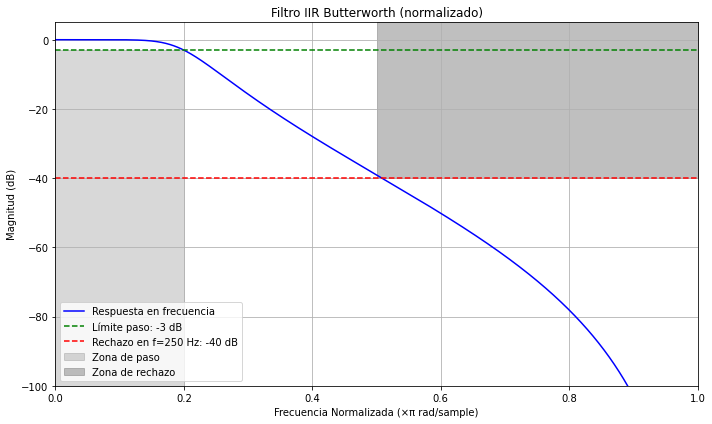

In [306]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.signal as sig




fc = 100         # Frecuencia de corte en Hz
orden = 4        # Orden del filtro
f_objetivo = 250 # Donde quiero que empiece a rechazar fuertemente
atenuacion_rechazo_db = -40
fs = 1000        # Frecuencia de muestreo

coef_num, coef_den  = graficar_filtro_iir_(fc, orden, f_objetivo, atenuacion_rechazo_db, fs=fs)